In [2]:
from pickle import load, dump
from os import makedirs
from os.path import dirname

import pandas as pd

In [3]:
def predict_data(data, model, ml_model: str, lags, **kwargs):
    if ml_model[0: 3] == 'svr' or ml_model[0: 3] == 'mlp' or ml_model[0:2] == 'rf':
        data = data.testing_set
        return model.predict(data[:, lags])
    elif ml_model[0: 7] == 'xgboost':
        data = data.testing_set

        return model.predict(data[:, lags])
    elif ml_model[0: 4] == 'lstm':
        data = data.testing_set
        data = data[:, lags]
        data = data.reshape((data.shape[0], data.shape[1], 1))
        return model.predict(data).ravel()
    elif ml_model[0: 3] in ['dee', 'tft']:
        data = data.testing_x
        pred = []

        for d in data:
            predictions = model.predict(d)

            for x in predictions:
                pred.append(x.mean[0])

        return pred

    elif ml_model[0: 6] == 'da-rnn':
        data = data.testing_x
        import torch

        with torch.no_grad():
            a = model(data.cuda())

        return list(a.cpu().repeat(1, 2).numpy()[:, -1])

    elif ml_model[0: 5] == 'arima':
        data = data.testing_set
        arima_forecast = kwargs.get('arima_forecast')
        if arima_forecast:
            if arima_forecast == 'in_sample':
                return model.predict_in_sample(data)[data]
            elif arima_forecast == 'out_sample':
                return model.predict(data + 1)[-1]
        else:
            return model.predict(len(data))

In [15]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import numpy as np
import io
summary_str = io.StringIO()

# CPU
lags = [0, 10, 10, 20, 10, 60, 50, 60, 50, 30, 10]
# Memory
#lags = [0, 30, 30, 10, 30, 50, 60, 40, 20, 50, 60]
# Response Time
#lags = [0, 10, 20, 20, 40, 30, 20, 10, 60, 50, 10]
# Traffic
#lags = [0, 40, 30, 20, 10, 50, 30, 60, 10, 30, 30]
modelos = ['svr']

for metrica in ['cpu']:
    for index in range(1, 10):
        parameters = []
        summary_str = io.StringIO()
        
        for modelo in modelos:            
            #for lag in lags:
            lag = lags[index]
            
            # Open the pickle file and load the model manually using torch.load
            with open('pickle/microservice '+str(index)+'/'+metrica+'/hyper_parameter/'+modelo+str(lag)+'.pkl', 'rb') as f:
                model = load(f)  # Load the object
            
            # Now manually load the PyTorch model onto the CPU
            if isinstance(model, torch.nn.Module):
                model = torch.load(f, map_location=torch.device('cpu'))

            preprocessor = model['preprocessor']
            real_values = load(open('pickle/microservice '+str(index)+'/'+metrica+'/hyper_parameter/svr'+str(lag)+'.pkl', 'rb'))['preprocessor'].testing_set[:, -1]
            real = load(open('pickle/microservice '+str(index)+'/'+metrica+'/hyper_parameter/svr'+str(lag)+'.pkl', 'rb'))['preprocessor'].time_series
            modeloo = model['model']

            predicao = predict_data(preprocessor, modeloo, modelo, preprocessor.lags)

            std_testingset = np.std(model['preprocessor'].testing_set, axis=1)
            error_per_window = (predicao - real_values)**2
            
            d = {'Error': error_per_window, 'Std': std_testingset}
            
            df = pd.DataFrame(data=d)

            correlation = df["Error"].corr(df["Std"])
            print(metrica+" "+str(index), "\t", real.mean(), "\t", correlation)
            

cpu 1 	 0.3423222518939502 	 0.20525807795145237
cpu 2 	 0.17556952791368718 	 0.15685808540976653
cpu 3 	 0.1687834442001033 	 0.2055269712368552
cpu 4 	 0.34442705450573363 	 0.14869019515151233
cpu 5 	 0.12523961417423213 	 0.17710211940484227
cpu 6 	 0.17958360489417605 	 0.09329577636299195
cpu 7 	 0.08327713383438849 	 0.0955494611217134
cpu 8 	 0.37816050498376047 	 0.09558778287520736
cpu 9 	 0.09677894944330115 	 0.05707283634823212


In [16]:
# Plot the Correlation

/tmp/ipykernel_695317/3600459427.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df["Series"], y=df["CPU"], palette="coolwarm", color="blue", s=100, label='CPU')
/tmp/ipykernel_695317/3600459427.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=range(1, 11), y=df["Memory"], palette="coolwarm", color="red", s=100, label='Memory')
/tmp/ipykernel_695317/3600459427.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=range(1, 11), y=df["Response Time"], palette="coolwarm", color="green", s=100, label='Response Time')
/tmp/ipykernel_695317/3600459427.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=range(1, 11), y=df["Traffic"], palette="coolwarm", color="purple", s=100, label='Traffic')


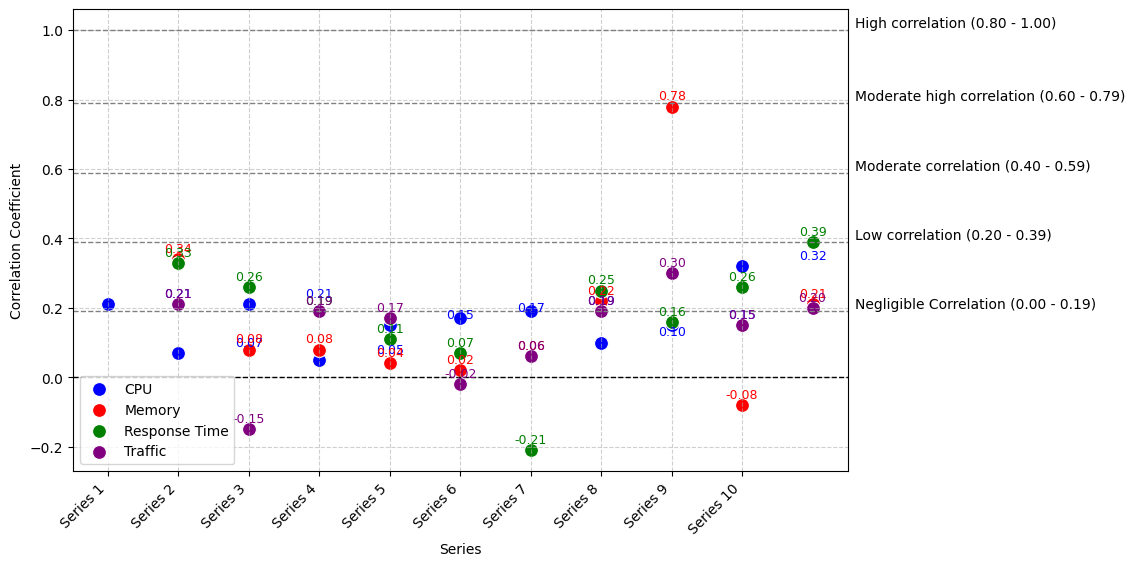

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = {
    "Series": ["Series 1", "Series 2", "Series 3", "Series 4", "Series 5",
               "Series 6", "Series 7", "Series 8", "Series 9", "Series 10"],
        "CPU": [0.21, 0.07, 0.21, 0.05, 0.15, 0.17, 0.19, 0.10, 0.15, 0.32],
    "Memory": [0.34, 0.08, 0.08, 0.04, 0.02, 0.06, 0.22, 0.78, -0.08, 0.21],
    "Response Time": [0.33, 0.26, 0.19, 0.11, 0.07, -0.21, 0.25, 0.16, 0.26, 0.39],
    "Traffic": [0.21, -0.15, 0.19, 0.17, -0.02, 0.06, 0.19, 0.30, 0.15, 0.20]
}

# Create DataFrame
df = pd.DataFrame(data)

# Create scatter plot with correlation labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["Series"], y=df["CPU"], palette="coolwarm", color="blue", s=100, label='CPU')
sns.scatterplot(x=range(1, 11), y=df["Memory"], palette="coolwarm", color="red", s=100, label='Memory')
sns.scatterplot(x=range(1, 11), y=df["Response Time"], palette="coolwarm", color="green", s=100, label='Response Time')
sns.scatterplot(x=range(1, 11), y=df["Traffic"], palette="coolwarm", color="purple", s=100, label='Traffic')


# Add horizontal lines for correlation levels
corr_levels = {
    "Negligible Correlation (0.00 - 0.19)": 0.19,
    "Low correlation (0.20 - 0.39)": 0.39,
    "Moderate correlation (0.40 - 0.59)": 0.59,
    "Moderate high correlation (0.60 - 0.79)": 0.79,
    "High correlation (0.80 - 1.00)": 1.00
}

for label, value in corr_levels.items():
    plt.axhline(y=value, color='gray', linestyle='--', linewidth=1)
    plt.text(10.6, value, label, verticalalignment="bottom", fontsize=10, color="black")


# # Add text labels to each point
for i in range(len(df)):
    plt.text(i + 1, df["CPU"][i] + 0.02, f"{df['CPU'][i]:.2f}", ha="center", fontsize=9, color="blue")
    plt.text(i + 1, df["Memory"][i] + 0.02, f"{df['Memory'][i]:.2f}", ha="center", fontsize=9, color="red")
    plt.text(i + 1, df["Response Time"][i] + 0.02, f"{df['Response Time'][i]:.2f}", ha="center", fontsize=9, color="green")
    plt.text(i + 1, df["Traffic"][i] + 0.02, f"{df['Traffic'][i]:.2f}", ha="center", fontsize=9, color="purple")

# Labels and title
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()